In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

folder1_path = "covid"
folder2_path = "normal"


image_size = (264, 264)

data = []
labels = []


def one_hot(data):
    a= list(set(data))
    ohe = np.zeros((len(data),len(set(data))))
    for i in range(len(data)):
        ind = a.index(data[i])
        ohe[i][ind] = 1
    
    return ohe



for filename in os.listdir(folder1_path):
    img = cv2.imread(os.path.join(folder1_path, filename))
    if img is not None:
        img = cv2.resize(img, image_size) if image_size else img
        data.append(img)
        labels.append(0)  

for filename in os.listdir(folder2_path):
    img = cv2.imread(os.path.join(folder2_path, filename))
    if img is not None:
        img = cv2.resize(img, image_size) if image_size else img
        data.append(img)
        labels.append(1)  

data = np.array(data)
labels = one_hot(labels)
labels = np.array(labels)
data = data/255.0

train_data, r_data, train_labels, r_labels = train_test_split(data, labels, test_size=0.3, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(r_data, r_labels, test_size=0.5, random_state=42)


# Print the shapes of the resulting datasets
print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("val data shape:", val_data.shape)
print("val labels shape:", val_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)


Training data shape: (842, 264, 264, 3)
Training labels shape: (842, 2)
val data shape: (181, 264, 264, 3)
val labels shape: (181, 2)
Test data shape: (181, 264, 264, 3)
Test labels shape: (181, 2)


In [2]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


# Define the CNN model architecture
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(264,264, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='softmax')  # Assuming 2 classes
])

2023-09-13 22:09:51.716433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 22:09:59.427783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-13 22:10:09.357414: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)



In [5]:
history = model.fit(train_data, train_labels, epochs=50, batch_size=64, validation_data=(val_data,val_labels), callbacks=[early_stopping])




2023-09-13 22:10:24.177456: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 704208384 exceeds 10% of free system memory.


Epoch 1/50


2023-09-13 22:10:27.957464: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 562331648 exceeds 10% of free system memory.
2023-09-13 22:10:28.598798: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 272646144 exceeds 10% of free system memory.
2023-09-13 22:10:29.308673: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 272646144 exceeds 10% of free system memory.
2023-09-13 22:10:30.442000: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 281165824 exceeds 10% of free system memory.


14/14 [==============================] - 46s 3s/step - loss: 0.6535 - accuracy: 0.6924 - val_loss: 0.1608 - val_accuracy: 0.9392
Epoch 2/50
14/14 [==============================] - 40s 3s/step - loss: 0.3652 - accuracy: 0.8622 - val_loss: 0.2752 - val_accuracy: 0.9006
Epoch 3/50
14/14 [==============================] - 39s 3s/step - loss: 0.1553 - accuracy: 0.9394 - val_loss: 0.1800 - val_accuracy: 0.9227
Epoch 4/50
14/14 [==============================] - 37s 3s/step - loss: 0.1224 - accuracy: 0.9549 - val_loss: 0.1036 - val_accuracy: 0.9558
Epoch 5/50
14/14 [==============================] - 37s 3s/step - loss: 0.0714 - accuracy: 0.9751 - val_loss: 0.0940 - val_accuracy: 0.9613
Epoch 6/50
14/14 [==============================] - 39s 3s/step - loss: 0.0630 - accuracy: 0.9822 - val_loss: 0.1597 - val_accuracy: 0.9392
Epoch 7/50
14/14 [==============================] - 38s 3s/step - loss: 0.1045 - accuracy: 0.9572 - val_loss: 0.1037 - val_accuracy: 0.9558
Epoch 8/50
14/14 [=============

In [6]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test accuracy:', test_acc)


6/6 [==============================] - 2s 252ms/step - loss: 0.1302 - accuracy: 0.9503
Test accuracy: 0.950276255607605


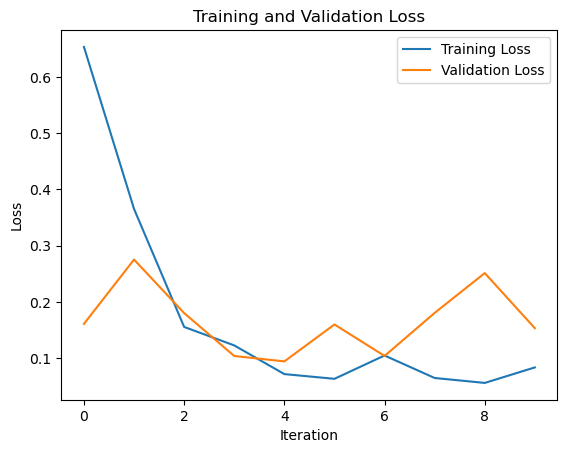

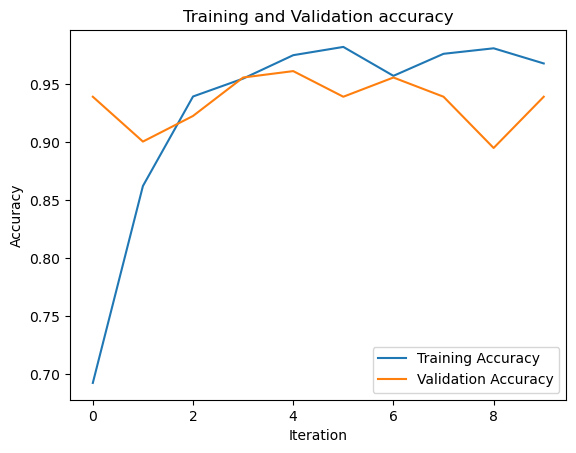

In [7]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()




plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
